In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from collections import OrderedDict

In [2]:
SNRdir = r'C:\Users\Lehnert Lab\Desktop\mexDynamicScanning\scanDir\vis'

visSmoothed = np.loadtxt(os.path.join(SNRdir, 'visSmoothed.csv'), delimiter=",")
# np.savetxt(os.path.join(SNRdir, 'visSmoothed.csv'), np.power(visSmoothed,3), delimiter=",")

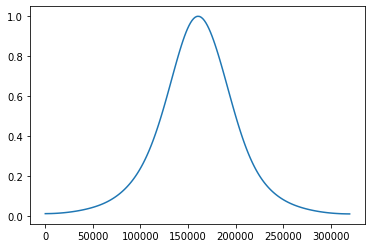

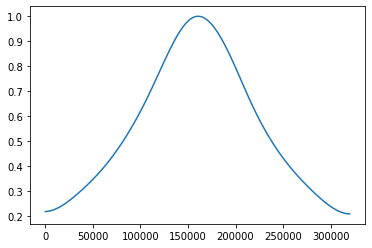

In [3]:
plt.plot(visSmoothed)
plt.show()

plt.plot(np.loadtxt(os.path.join(SNRdir, r'oldVis\visSmoothed.csv'), delimiter=","))

In [5]:
# Step 1: Read the CSV file
csv_file_path = r'C:\Users\Lehnert Lab\Desktop\mexDynamicScanning\scanDir\vis\visFreq.csv'  # Replace this with the path to your CSV file
df = pd.read_csv(csv_file_path)

# Step 2: Multiply every element by a factor
factor = 1e6  # Replace this with your desired factor
df = df * factor

# Step 3: Save the updated DataFrame back to the original CSV
df.to_csv(csv_file_path, index=False)

KeyboardInterrupt: 

#### Splitting Data By Scan Time

In [4]:
def timeString(fileName):
    return '_'.join(fileName.split('-')[2:]).replace('.csv','').split('_')

scanPath = r'C:\Users\Lehnert Lab\Desktop\mexDynamicScanning\scanDir\save\data'
files = [f for f in os.listdir(scanPath)]
times = [timeString(name) for name in files]

In [5]:
times

[['19', '14', '26', '48'],
 ['19', '14', '29', '13'],
 ['19', '14', '31', '39'],
 ['19', '14', '34', '06'],
 ['19', '14', '36', '33'],
 ['19', '14', '38', '59'],
 ['19', '14', '41', '26'],
 ['19', '14', '43', '54'],
 ['19', '14', '46', '26']]

In [6]:
splitIndices = []

for i in range(len(times)-1):
    time1=times[i]; time2=times[i+1]
    
    if ((int(time2[0])*1440 + int(time2[1])*60 + int(time2[2]) + int(time2[3])/60) -
        (int(time1[0])*1440 + int(time1[1])*60 + int(time1[2]) + int(time1[3])/60)
        < 1
       ):
        splitIndices.append(i)

[files[i] for i in splitIndices]

[]

# Processing Runs

## Load Data

In [77]:
runData = {}
metrics = {}

In [78]:
runPath = r'C:\Users\Lehnert Lab\Desktop\mexDynamicScanning\scanDir\finalData'
runs = [f for f in os.listdir(runPath) if ('ignore' not in f)]

for run in runs:
    dataPath = runPath + '\\' + run + r'\data'
    runData[run] = [np.loadtxt(os.path.join(dataPath, file), delimiter=",") for file in os.listdir(dataPath)]
    
    metricPath = runPath + '\\' + run + r'\metrics'
    metrics[run] = [np.loadtxt(os.path.join(metricPath, file), delimiter=",") for file in os.listdir(metricPath)]
    
    
    if not runData[run]:
        del runData[run]
        del metrics[run]

In [42]:
customDataPath = r'C:\Users\Lehnert Lab\Desktop\mexDynamicScanning\scanDir\save\data'
runData['custom'] = [np.loadtxt(os.path.join(customDataPath, file), delimiter=",") for file in os.listdir(customDataPath)]

dynamicMetricPath = r'C:\Users\Lehnert Lab\Desktop\mexDynamicScanning\scanDir\save\metrics'
metrics['custom'] = [np.loadtxt(os.path.join(dynamicMetricPath, file), delimiter=",") for file in os.listdir(dynamicMetricPath)]

## Comparison Figure of Merit

In [9]:
def sliceCenter(arr, fraction=0.8):
    startIndex = int( (0.5 - fraction/2) * len(arr))
    endIndex = int( (0.5 + fraction/2) * len(arr))
    
    return np.array(arr[startIndex:endIndex])

In [15]:
for run in ['22','22p5']:
    del runData[run]
    del metrics[run]

KeyError: '22'

In [79]:
def timeCosts(target, centerWindow):
    analysis = {}; lines = {}
    
    minLength = np.min([len(runData[key][-1][1]) for key in runData.keys()])

    for key in runData.keys():
        currLength = len(runData[key][-1][1])
        
        exclusionLine = sliceCenter(runData[key][-1][0], centerWindow)/target
        axis = sliceCenter(runData[key][-1][1], centerWindow)

        runMetrics = sliceCenter(metrics[key][-1], centerWindow)
        avgScanTime = np.mean(runMetrics)


        aboveTarget = np.array([y for y in exclusionLine if y > 1])
        rescanCost = np.sum(160 * avgScanTime * (aboveTarget**2 - 1))
        # For more rigorous calc of prefactor, should take total steps through the window weighted by SNR^2 (see below)


        lines[key] = [exclusionLine, axis]

        analysis[key] = [rescanCost/100/60, len(aboveTarget)*minLength/currLength, runMetrics.sum()/100/60]
        
    return analysis
    

target = 7.6e-4; centerWindow = 0.62; fixedCost = 1.5
# target = 1.45e-3; centerWindow = 0.7; fixedCost = 1.5

analysis = timeCosts(target, centerWindow); analysis = OrderedDict(sorted(analysis.items()))
analysis

OrderedDict([('19', [26.954160416491128, 27.0, 196.33333333333334]),
             ('19p5', [6.1890328680955236, 7.0, 201.5]),
             ('20', [6.204002490581714, 4.0, 206.66666666666666]),
             ('20p5', [0.8215508317197738, 3.0, 211.83333333333334]),
             ('21', [0.0, 0.0, 217.0]),
             ('dynamic',
              [0.7980749005196813, 2.5843592891583618, 204.08016666666666])])

In [25]:
analysis['dynamic'] = [0,0,250]

In [80]:
for key in ['21p5', '22']:
    keyVals = list(analysis.keys())
    scanTime = analysis[keyVals[-2]][2] + analysis[keyVals[-2]][2] - analysis[keyVals[-3]][2]
    
    analysis[key] = [0, 0, scanTime]
    analysis = OrderedDict(sorted(analysis.items()))
    
analysis

OrderedDict([('19', [26.954160416491128, 27.0, 196.33333333333334]),
             ('19p5', [6.1890328680955236, 7.0, 201.5]),
             ('20', [6.204002490581714, 4.0, 206.66666666666666]),
             ('20p5', [0.8215508317197738, 3.0, 211.83333333333334]),
             ('21', [0.0, 0.0, 217.0]),
             ('21p5', [0, 0, 222.16666666666666]),
             ('22', [0, 0, 227.33333333333331]),
             ('dynamic',
              [0.7980749005196813, 2.5843592891583618, 204.08016666666666])])

In [56]:
fixedCost = 2; currMax=0;

for target, centerWindow in zip(np.linspace(7.3e-4, 7.8e-4, 100), np.linspace(0.5,0.7,100)):
    times = timeCosts(target, centerWindow);
    
    minSpeedup = np.min( [ (times[key][0] + fixedCost * times[key][1] + times[key][2]) / \
                           (times['dynamic'][0] + fixedCost * times['dynamic'][1] + times['dynamic'][2]) \
                           for key in times.keys() if key != 'dynamic' ] )
    
    if currMax < minSpeedup:
        currMax = minSpeedup
        bestParams = (target, centerWindow)

print(currMax)
print(bestParams)

1.0331977149147327
(0.0007618181818181818, 0.6272727272727272)


In [12]:
fixedCost = 1.5; currMax=0;

for target, centerWindow in zip(np.linspace(1.42e-3, 1.46e-3, 100), np.linspace(0.5,0.75,100)):
    times = timeCosts(target, centerWindow);
    
    minSpeedup = np.min( [ (times[key][0] + fixedCost * times[key][1] + times[key][2]) / \
                           (times['dynamic'][0] + fixedCost * times['dynamic'][1] + times['dynamic'][2]) \
                           for key in times.keys() if key != 'dynamic' ] )
    
    if currMax < minSpeedup:
        currMax = minSpeedup
        bestParams = (target, centerWindow)

print(currMax)
print(bestParams)

0.9535810145700486
(0.00146, 0.75)


In [82]:
analysis

OrderedDict([('19', [26.954160416491128, 27.0, 196.33333333333334]),
             ('19p5', [6.1890328680955236, 7.0, 201.5]),
             ('20', [6.204002490581714, 4.0, 206.66666666666666]),
             ('20p5', [0.8215508317197738, 3.0, 211.83333333333334]),
             ('21', [0.0, 0.0, 217.0]),
             ('21p5', [0, 0, 222.16666666666666]),
             ('22', [0, 0, 227.33333333333331]),
             ('dynamic',
              [0.7980749005196813, 2.5843592891583618, 204.08016666666666])])

Minimum y value along the line at x=1.5: 1.0438962862630405


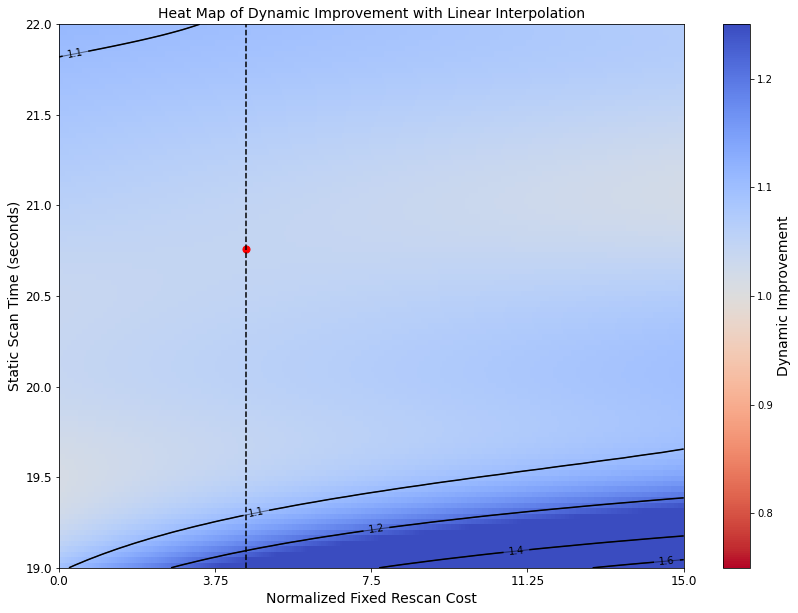

In [84]:
from scipy.interpolate import RegularGridInterpolator

interpolate_values = True  # Set to False to disable interpolation
interpolation_method = 'linear'  # Can be 'linear' or 'cubic'


# Define x values (fixed rescan cost) range
x_values = np.linspace(0, 5, 100)

# Define y values (keys from the dictionary excluding 'dynamic')
y_labels = list(analysis.keys())[:-1]  # Exclude 'dynamic'
y_indices = np.arange(len(y_labels))

# Initialize an empty array to store dynamic improvement values
dynamic_improvement = np.zeros((len(y_labels), len(x_values)))

# Calculate dynamic improvement for each y and x
for i, y in enumerate(y_labels):
    for j, x in enumerate(x_values):
        dyn_imp = (analysis[y][0] + x * analysis[y][1] + analysis[y][2]) / \
                  (analysis['dynamic'][0] + x * analysis['dynamic'][1] + analysis['dynamic'][2])
                  
        dynamic_improvement[i, j] = dyn_imp

        
X, Y = np.meshgrid(x_values, y_indices)
        

    
if interpolate_values:
    # Prepare the original grid points and the values on the grid
    points = [y_indices, x_values]
    values = dynamic_improvement
    
    # Create the interpolator object
    interp = RegularGridInterpolator(points, values, method='cubic')
    
    # Create a finer grid
    fine_y_indices = np.linspace(y_indices.min(), y_indices.max(), 100)
    fine_x_values = np.linspace(x_values.min(), x_values.max(), 300)
    fine_meshgrid = np.meshgrid(fine_y_indices, fine_x_values, indexing='ij')
    fine_points = np.reshape(fine_meshgrid, (2, -1)).T
    
    # Interpolate on the finer grid
    interp_values = interp(fine_points).reshape(100, 300)
    
    # Set data for plotting
    plot_data = interp_values
    x_plot, y_plot = fine_x_values, fine_y_indices
else:
    # Set data for plotting without interpolation
    plot_data = dynamic_improvement
    x_plot, y_plot = x_values, y_indices

    
    
# Plotting
plt.figure(figsize=(14, 10))
plt.imshow(plot_data, cmap='coolwarm_r', aspect='auto', origin='lower', \
           extent=[x_values.min(), x_values.max(), 0, len(y_labels)-1], interpolation='none', \
           vmin=0.75, vmax=1.25)
cbar = plt.colorbar(label='Dynamic Improvement')
cbar.set_label('Dynamic Improvement', size=14)  # Set the label with the desired font size
plt.xticks(np.linspace(x_values.min(), x_values.max(), num=5), np.linspace(x_values.min(), x_values.max(), num=5)*3) #Normalize to 20s integration time
custom_y_labels = np.linspace(19,22,num=7)
plt.yticks(np.linspace(0, len(y_labels)-1, num=len(y_labels)), custom_y_labels)


# If interpolating, add contour lines
if interpolate_values:
    contour_levels = [0.6, 0.8, 0.9, 1.0, 1.1, 1.2, 1.4, 1.6]
    fine_meshgrid_for_contours = np.meshgrid(fine_x_values, fine_y_indices, indexing='xy')
    plt.contour(fine_meshgrid_for_contours[0], fine_meshgrid_for_contours[1], plot_data, levels=contour_levels, colors='k', linestyles='solid', linewidths=1, alpha=0.5)
    plt.clabel(plt.contour(fine_meshgrid_for_contours[0], fine_meshgrid_for_contours[1], plot_data, levels=contour_levels, colors='k'), inline=1, fontsize=10, fmt='%1.1f')

plt.xlabel('Normalized Fixed Rescan Cost', fontsize=14)
plt.ylabel('Static Scan Time (seconds)', fontsize=14)
plt.title('Heat Map of Dynamic Improvement' + (' with Linear Interpolation' if interpolate_values else ''), fontsize=14)



# Vertical line cut
given_x_value = 1.5
plt.axvline(x=given_x_value, color='k', linestyle='--')

x_index = np.abs(fine_x_values - given_x_value).argmin()
min_y_value = np.min(plot_data[:, x_index])
min_y_index = np.argmin(plot_data[:, x_index])

# Calculate the y position for the red dot (use fine_y_indices to find the actual y value)
y_position_for_dot = fine_y_indices[min_y_index]
plt.scatter(given_x_value, y_position_for_dot, color='r', s=50)

# Print the minimum value
print(f"Minimum y value along the line at x={given_x_value}: {min_y_value}")

plt.tick_params(axis='both', labelsize=12)
plt.show()

## Diagnostic Plots

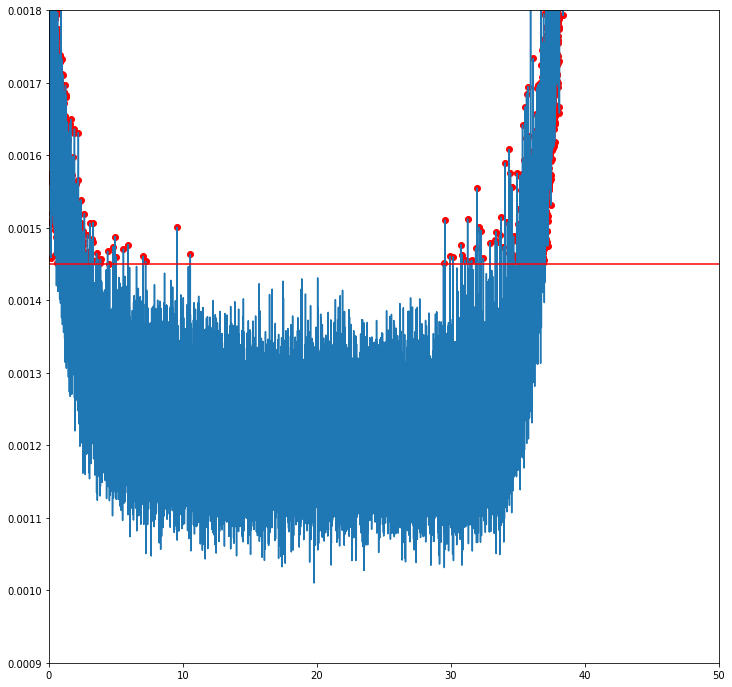

In [43]:
target = 1.45e-3
plt.figure(figsize=(12,12))

for line in [runData['custom'][-1]]: 
    plt.plot(line[1], line[0])
    
    above_target_x = np.array([x for x, y in zip(line[1], line[0]) if y > target])
    above_target_y = np.array([y for y in line[0] if y > target])
    plt.scatter(above_target_x, above_target_y, color="r")
    
    
plt.axhline(y=target, color="r", linestyle="-", label="Target Exclusion")
    
plt.ylim([9e-4,1.8e-3])
plt.xlim([0,50])

plt.show()

In [44]:
finalMetrics = metrics['custom'][-1]

# Slice specific scan metrics
startIndex = int(0 * len(finalMetrics))
endIndex = int(1 * len(finalMetrics))

finalMetrics = finalMetrics[startIndex:endIndex]

np.mean(finalMetrics)

1092.8169014084508

In [117]:
metrics['dynamic']

[array(2200.),
 array([2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200.,
        2200., 2200.]),
 array([2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200.,
        2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200.,
        2200., 2200., 2200.]),
 array([2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200.,
        2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200.,
        2200., 2200., 2200., 2200., 2200., 1936., 1950., 1945., 1953.,
        1955., 1932., 1928., 2200.]),
 array([2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200.,
        2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200.,
        2200., 2200., 2200., 2200., 2200., 1936., 1950., 1945., 1953.,
        1955., 1932., 1928., 2200., 1990., 1947., 1925., 2200., 2200.,
        2200., 2200., 2200., 2200., 2200.]),
 array([2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200.,
        2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200., 22

In [152]:
targets = np.loadtxt(r'C:\Users\Lehnert Lab\Desktop\mexDynamicScanning\scanDir\state\inProgressTargets.csv', delimiter=',')
points = np.loadtxt(r'C:\Users\Lehnert Lab\Desktop\mexDynamicScanning\scanDir\state\points.csv', delimiter=',')
line = np.loadtxt(r'C:\Users\Lehnert Lab\Desktop\mexDynamicScanning\scanDir\runs\seed\data\exclusionLine_2024-03-11_15-14-35.csv', delimiter=',')
SNR = np.loadtxt(r'C:\Users\Lehnert Lab\Desktop\mexDynamicScanning\scanDir\state\trimmedSNR.csv', delimiter=',')

print(len(targets))
print(len(runData['dynamic'][0][1]))

print(len(line[1]))

25599
45799
25599


In [273]:
totSum = np.sum(np.power(SNR,2)); totSum
cumSum = [np.sum(np.power(SNR[:j], 2)) for j in range(len(SNR))]/totSum

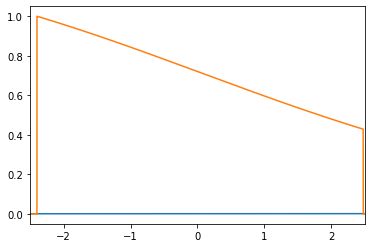

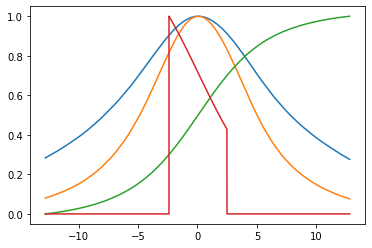

In [276]:
plt.plot(line[1], targets)
plt.plot(line[1], points)

plt.xlim([-2.5,2.5])

plt.show()

plt.plot(line[1], SNR)
plt.plot(line[1], np.power(SNR,2))
plt.plot(line[1], cumSum)
plt.plot(line[1], points)

plt.show()

158.62689972282806


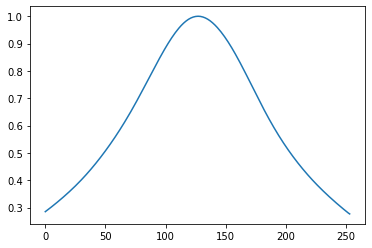

In [288]:
frequencies = line[1]

# Define the interval and initialize variables
interval = 0.1  # 100kHz in MHz
windowedSNR = []
current_freq = frequencies[0]

current_interval_SNR = []

for freq, snr in zip(frequencies, SNR):
    if freq - current_freq <= interval:
        current_interval_SNR.append(snr)
    else:
        windowedSNR.append(np.mean(current_interval_SNR))
        current_interval_SNR = [snr]
        current_freq = freq

# Add the last interval
if current_interval_SNR:
    windowedSNR.append(np.mean(current_interval_SNR))

    
# prefactor for rescan cost
print(np.sum(windowedSNR))


plt.plot(windowedSNR)
plt.show()

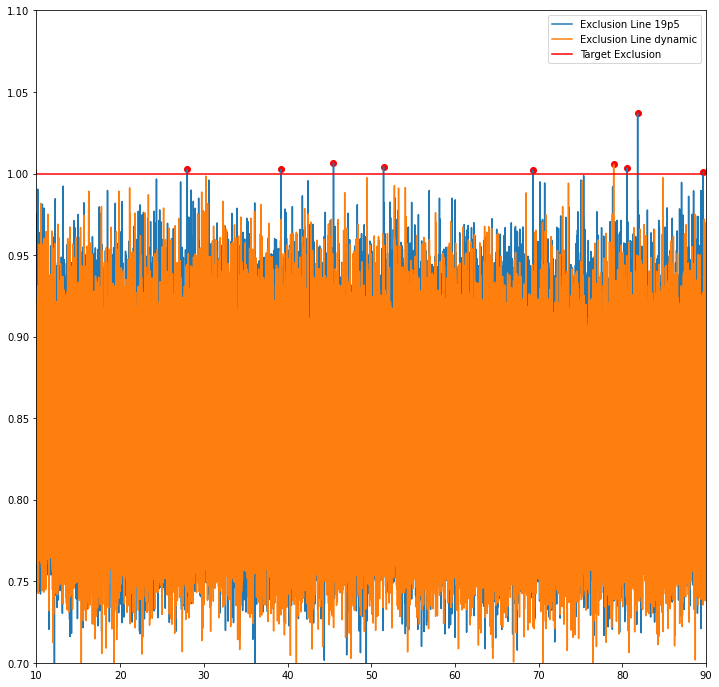

In [96]:
target = 7.6e-4

plt.figure(figsize=(12,12))

for key in ['19p5']:
    line = runData[key][-1]
    
    label = f"Exclusion Line {key}"
    plt.plot(line[1], line[0]/target, label=label)
    
    above_target_x = np.array([x for x, y in zip(line[1], line[0]) if y > target])
    above_target_y = np.array([y for y in line[0] if y > target])
    plt.scatter(above_target_x, above_target_y/target, color="r")
    
    
for key in ['dynamic']:
    line = runData[key][-1]
    
    label = f"Exclusion Line {key}"
    plt.plot(line[1], line[0]/target, label=label)
    
    above_target_x = np.array([x for x, y in zip(line[1], line[0]) if y > target])
    above_target_y = np.array([y for y in line[0] if y > target])
    plt.scatter(above_target_x, above_target_y/target, color="r")

    
    
plt.axhline(y=1, color="r", linestyle="-", label="Target Exclusion")

plt.ylim([0.7,1.1])
plt.xlim([10,90])


plt.legend()
plt.show()

In [12]:
print(len(runData['19'][-1][1][:-1]))
print(len(runData['19'][-1][1][1:]))

6288249
6288249


(1187.0, 1188.0)

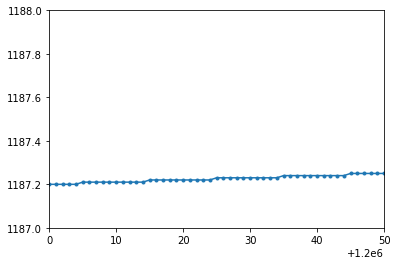

In [16]:
plt.plot(runData['19'][-1][1][:-1], marker='.')

plt.xlim([1.2e6, 1.20005e6])
plt.ylim([1.187e3, 1.188e3])

# Old

In [2]:
savePath = r'C:\Users\Lehnert Lab\Desktop\mexDynamicScanning\scanDir\save'

# Get a list of all .csv files in the "data" folder
metric_folder = savePath + r'\metrics'
metric_files = [f for f in os.listdir(metric_folder) if f.endswith(".csv")]

# Load data from each .csv file and store it in the data_arrays list
metric_arrays = []
for csv_file in metric_files:
    file_path = os.path.join(metric_folder, csv_file)
    data = np.loadtxt(file_path, delimiter=",")
    metric_arrays.append(data)


# Get a list of all .csv files in the "data" folder
data_folder = savePath + r'\data'
csv_files = [f for f in os.listdir(data_folder) if f.endswith(".csv")]

# Load data from each .csv file and store it in the data_arrays list
data_arrays = []
for csv_file in csv_files:
    file_path = os.path.join(data_folder, csv_file)
    data = np.loadtxt(file_path, delimiter=",")
    data_arrays.append(data)


print(metric_arrays)

[array(1900.), array([1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
       1900., 1900.]), array([1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
       1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
       1900., 1900., 1900.]), array([1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
       1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
       1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
       1900., 1900., 1900., 1900.]), array([1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
       1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
       1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
       1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
       1900., 1900., 1900., 1900., 1900.]), array([1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
       1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
       1900

In [20]:
final19 = np.loadtxt(os.path.join(data_folder, 'exclusionLine_2024-03-06_21-41-52.csv'), delimiter = ',')
first19p5 = np.loadtxt(os.path.join(data_folder, 'exclusionLine_2024-03-06_21-42-16.csv'), delimiter = ',')

In [24]:
len(final19[0])

291599

In [23]:
len(first19p5[0])

25599

In [27]:
split_data = []
foo = data_arrays[0]

for i in range(1, len(data_arrays)-1):
    if len(data_arrays[i-1][0]) > len(data_arrays[i][0]):
        split_data += [foo]
        foo = []
        
    foo = np.append(foo, [data_arrays[i]])

In [29]:
split_data

array([  0.   ,   0.   ,   0.   , ..., 278.797, 278.798, 278.799])

In [15]:
diff = len(data_arrays[1][0])

28359

In [14]:
len(data_arrays[-1][0])

291599

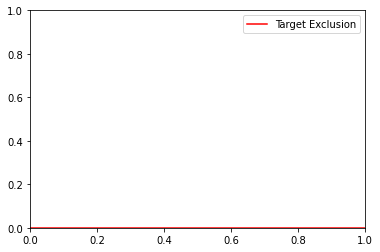

In [40]:
# Plot each data array in data_arrays
target = 4.2e-5
plt.figure()

for i, data in enumerate(data_arrays):
    label = f"Exclusion Line {i + 1}"
    plt.plot(data[1], data[0], label=label)
plt.axhline(y=target, color="r", linestyle="-", label="Target Exclusion")




plt.legend()
plt.show()